In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = f"""
execution:
    exp_id: exp_033
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs
    cand_exp_dir: None
    use_cand: False

feature:
    agg_freq: 12 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.01  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    tree_method: "gpu_hist"
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
if CFG["dataset"]["use_cand"]:
    with open(os.path.join(CFG["dataset"]["cand_exp_dir"], "next_cands.pkl"), "rb") as f:
        next_cands = pickle.load(f)

## 特徴生成

In [4]:
def generate_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    timestamp = pd.to_datetime(train["timestamp"].values[0])
    total_seconds = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    train["total_seconds"] = (total_seconds + train.index * 5) % (24 * 60 * 60) # [sec]
    features.add_num_feature("total_seconds")    

    columns = ["anglez", "enmo"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["anglez_mean"] = train["total_seconds"].map(gb["anglez_mean"])
    train["enmo_mean"] = train["total_seconds"].map(gb["enmo_mean"])
    features.add_num_features(gb.columns.tolist())

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)
    
    columns += f_names
    columns += gb.columns.tolist()

    # rolling
    dts = [10, 50, 100, 1000]
    for dt in dts:      
        f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).mean()
        features.add_num_features(f_names)

        f_names = [f"{c}_rolling_std_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).std()
        features.add_num_features(f_names)

        f_names = [f"{c}_rolling_max_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).max()
        features.add_num_features(f_names)

        f_names = [f"{c}_rolling_min_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).min()
        features.add_num_features(f_names)

        f_names = [f"{c}_rolling_median_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).median()
        features.add_num_features(f_names)

        f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
        train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
        features.add_num_features(f_names)


    # 一定stepで集約
    series_id = train["series_id"].values[0]
    agg_freq = CFG["feature"]["agg_freq"]
    columns = features.all_features() + ["target", "step"]
    train = train[columns].groupby(train["step"].values // agg_freq).mean()
    train["series_id"] = series_id
    train["target"] = train["target"].round().astype(int)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def read_and_generate_features(file):
    train = pd.read_csv(file)
    train, features = generate_features(train)
    return train, features

In [5]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")

if CFG["execution"]["multiprocessing"]:
    with Pool(30) as pool:
        results = list(tqdm(pool.imap(read_and_generate_features, files), total=len(files)))
    dfs, features = zip(*results)
    train = pd.concat(dfs)
    features = features[0]

    del dfs, results
    gc.collect()
else:
    dfs = []
    for file in tqdm(files):
        train = pd.read_csv(file)
        train, features = generate_features(train)
        dfs.append(train)
    train = pd.concat(dfs)
    features = features[0]

100%|██████████| 277/277 [05:02<00:00,  1.09s/it]


## 学習

In [6]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

,anglez_diff_abs,anglez_diff_abs_rolling_max_10,anglez_diff_abs_rolling_max_100,anglez_diff_abs_rolling_max_1000,anglez_diff_abs_rolling_max_50,anglez_diff_abs_rolling_mean_10,anglez_diff_abs_rolling_mean_100,anglez_diff_abs_rolling_mean_1000,anglez_diff_abs_rolling_mean_50,anglez_diff_abs_rolling_median_10,...,enmo_rolling_square_mean_50,enmo_rolling_std_10,enmo_rolling_std_100,enmo_rolling_std_1000,enmo_rolling_std_50,total_seconds,target,step,series_id,fold
0,0.001618,0.024800,NaN,NaN,NaN,0.003565,NaN,NaN,NaN,0.000558,...,NaN,0.0,NaN,NaN,NaN,40527.5,1,5.5,af91d9a50547,3
1,0.010900,0.052400,NaN,NaN,NaN,0.009874,NaN,NaN,NaN,0.000362,...,NaN,0.0,NaN,NaN,NaN,40587.5,1,17.5,af91d9a50547,3
2,0.000000,0.000000,NaN,NaN,0.065400,0.000000,NaN,NaN,0.003021,0.000000,...,0.000000,0.0,NaN,NaN,0.000000,40647.5,1,29.5,af91d9a50547,3
3,0.000233,0.001667,NaN,NaN,0.032400,0.000384,NaN,NaN,0.001413,0.000008,...,0.000000,0.0,NaN,NaN,0.000000,40707.5,1,41.5,af91d9a50547,3
4,0.000783,0.002550,0.5969,NaN,0.318808,0.000637,0.022318,NaN,0.012749,0.000158,...,0.000002,0.0,0.00146,NaN,0.001204,40767.5,1,53.5,af91d9a50547,3


(10662195, 153)

In [7]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["xgboost"], 
    es_rounds=50
)
train["oof"] = trn_oof

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-logloss:0.68467
[50]	eval-logloss:0.40485
[100]	eval-logloss:0.27145
[150]	eval-logloss:0.20010
[200]	eval-logloss:0.15996
[250]	eval-logloss:0.13624
[300]	eval-logloss:0.12217
[350]	eval-logloss:0.11341
[400]	eval-logloss:0.10789
[450]	eval-logloss:0.10450
[500]	eval-logloss:0.10238
[550]	eval-logloss:0.10109
[600]	eval-logloss:0.10037
[650]	eval-logloss:0.09987
[700]	eval-logloss:0.09950
[750]	eval-logloss:0.09917
[800]	eval-logloss:0.09896
[850]	eval-logloss:0.09880
[900]	eval-logloss:0.09866
[950]	eval-logloss:0.09856
[1000]	eval-logloss:0.09852
[1050]	eval-logloss:0.09848
[1100]	eval-logloss:0.09845
[1150]	eval-logloss:0.09840
[1200]	eval-logloss:0.09837
[1250]	eval-logloss:0.09832
[1300]	eval-logloss:0.09828
[1350]	eval-logloss:0.09827
[1400]	eval-logloss:0.09823
[1450]	eval-logloss:0.09820
[1500]	eval-logloss:0.09825


 20%|██        | 1/5 [03:03<12:14, 183.64s/it]

== fold 1 ==
[0]	eval-logloss:0.68466
[50]	eval-logloss:0.40420
[100]	eval-logloss:0.26939
[150]	eval-logloss:0.19641
[200]	eval-logloss:0.15413
[250]	eval-logloss:0.12859
[300]	eval-logloss:0.11278
[350]	eval-logloss:0.10262
[400]	eval-logloss:0.09620
[450]	eval-logloss:0.09191
[500]	eval-logloss:0.08918
[550]	eval-logloss:0.08740
[600]	eval-logloss:0.08611
[650]	eval-logloss:0.08523
[700]	eval-logloss:0.08460
[750]	eval-logloss:0.08406
[800]	eval-logloss:0.08360
[850]	eval-logloss:0.08328
[900]	eval-logloss:0.08302
[950]	eval-logloss:0.08281
[1000]	eval-logloss:0.08258
[1050]	eval-logloss:0.08243
[1100]	eval-logloss:0.08224
[1150]	eval-logloss:0.08209
[1200]	eval-logloss:0.08201
[1250]	eval-logloss:0.08188
[1300]	eval-logloss:0.08178
[1350]	eval-logloss:0.08166
[1400]	eval-logloss:0.08159
[1450]	eval-logloss:0.08148
[1500]	eval-logloss:0.08145
[1550]	eval-logloss:0.08142
[1600]	eval-logloss:0.08134
[1650]	eval-logloss:0.08133
[1700]	eval-logloss:0.08131
[1750]	eval-logloss:0.08128
[1

 40%|████      | 2/5 [06:54<10:33, 211.17s/it]

== fold 2 ==
[0]	eval-logloss:0.68467
[50]	eval-logloss:0.40326
[100]	eval-logloss:0.26834
[150]	eval-logloss:0.19527
[200]	eval-logloss:0.15332
[250]	eval-logloss:0.12838
[300]	eval-logloss:0.11288
[350]	eval-logloss:0.10319
[400]	eval-logloss:0.09694
[450]	eval-logloss:0.09300
[500]	eval-logloss:0.09027
[550]	eval-logloss:0.08855
[600]	eval-logloss:0.08749
[650]	eval-logloss:0.08677
[700]	eval-logloss:0.08629
[750]	eval-logloss:0.08580
[800]	eval-logloss:0.08537
[850]	eval-logloss:0.08509
[900]	eval-logloss:0.08477
[950]	eval-logloss:0.08456
[1000]	eval-logloss:0.08442
[1050]	eval-logloss:0.08429
[1100]	eval-logloss:0.08424
[1150]	eval-logloss:0.08416
[1200]	eval-logloss:0.08406
[1250]	eval-logloss:0.08401
[1300]	eval-logloss:0.08402
[1306]	eval-logloss:0.08401


 60%|██████    | 3/5 [09:44<06:25, 192.73s/it]

== fold 3 ==
[0]	eval-logloss:0.68468
[50]	eval-logloss:0.40550
[100]	eval-logloss:0.27255
[150]	eval-logloss:0.20118
[200]	eval-logloss:0.16039
[250]	eval-logloss:0.13669
[300]	eval-logloss:0.12212
[350]	eval-logloss:0.11312
[400]	eval-logloss:0.10754
[450]	eval-logloss:0.10402
[500]	eval-logloss:0.10159
[550]	eval-logloss:0.10002
[600]	eval-logloss:0.09905
[650]	eval-logloss:0.09835
[700]	eval-logloss:0.09786
[750]	eval-logloss:0.09742
[800]	eval-logloss:0.09707
[850]	eval-logloss:0.09677
[900]	eval-logloss:0.09659
[950]	eval-logloss:0.09635
[1000]	eval-logloss:0.09622
[1050]	eval-logloss:0.09604
[1100]	eval-logloss:0.09587
[1150]	eval-logloss:0.09574
[1200]	eval-logloss:0.09571
[1250]	eval-logloss:0.09559
[1300]	eval-logloss:0.09548
[1350]	eval-logloss:0.09534
[1400]	eval-logloss:0.09521
[1450]	eval-logloss:0.09507
[1500]	eval-logloss:0.09497
[1550]	eval-logloss:0.09490
[1600]	eval-logloss:0.09478
[1650]	eval-logloss:0.09474
[1700]	eval-logloss:0.09470
[1750]	eval-logloss:0.09467
[1

 80%|████████  | 4/5 [13:45<03:31, 211.66s/it]

== fold 4 ==
[0]	eval-logloss:0.68474
[50]	eval-logloss:0.40775
[100]	eval-logloss:0.27632
[150]	eval-logloss:0.20651
[200]	eval-logloss:0.16678
[250]	eval-logloss:0.14352
[300]	eval-logloss:0.12946
[350]	eval-logloss:0.12091
[400]	eval-logloss:0.11574
[450]	eval-logloss:0.11239
[500]	eval-logloss:0.11018
[550]	eval-logloss:0.10868
[600]	eval-logloss:0.10779
[650]	eval-logloss:0.10711
[700]	eval-logloss:0.10662
[750]	eval-logloss:0.10628
[800]	eval-logloss:0.10588
[850]	eval-logloss:0.10561
[900]	eval-logloss:0.10535
[950]	eval-logloss:0.10524
[1000]	eval-logloss:0.10517
[1050]	eval-logloss:0.10500
[1100]	eval-logloss:0.10488
[1150]	eval-logloss:0.10479
[1200]	eval-logloss:0.10468
[1250]	eval-logloss:0.10458
[1300]	eval-logloss:0.10445
[1350]	eval-logloss:0.10436
[1400]	eval-logloss:0.10425
[1450]	eval-logloss:0.10415
[1500]	eval-logloss:0.10404
[1550]	eval-logloss:0.10400
[1600]	eval-logloss:0.10395
[1650]	eval-logloss:0.10391
[1700]	eval-logloss:0.10390
[1750]	eval-logloss:0.10385
[1

100%|██████████| 5/5 [18:01<00:00, 216.27s/it]


In [8]:
train = train.drop(columns=features.all_features())
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

## 予測値の作成

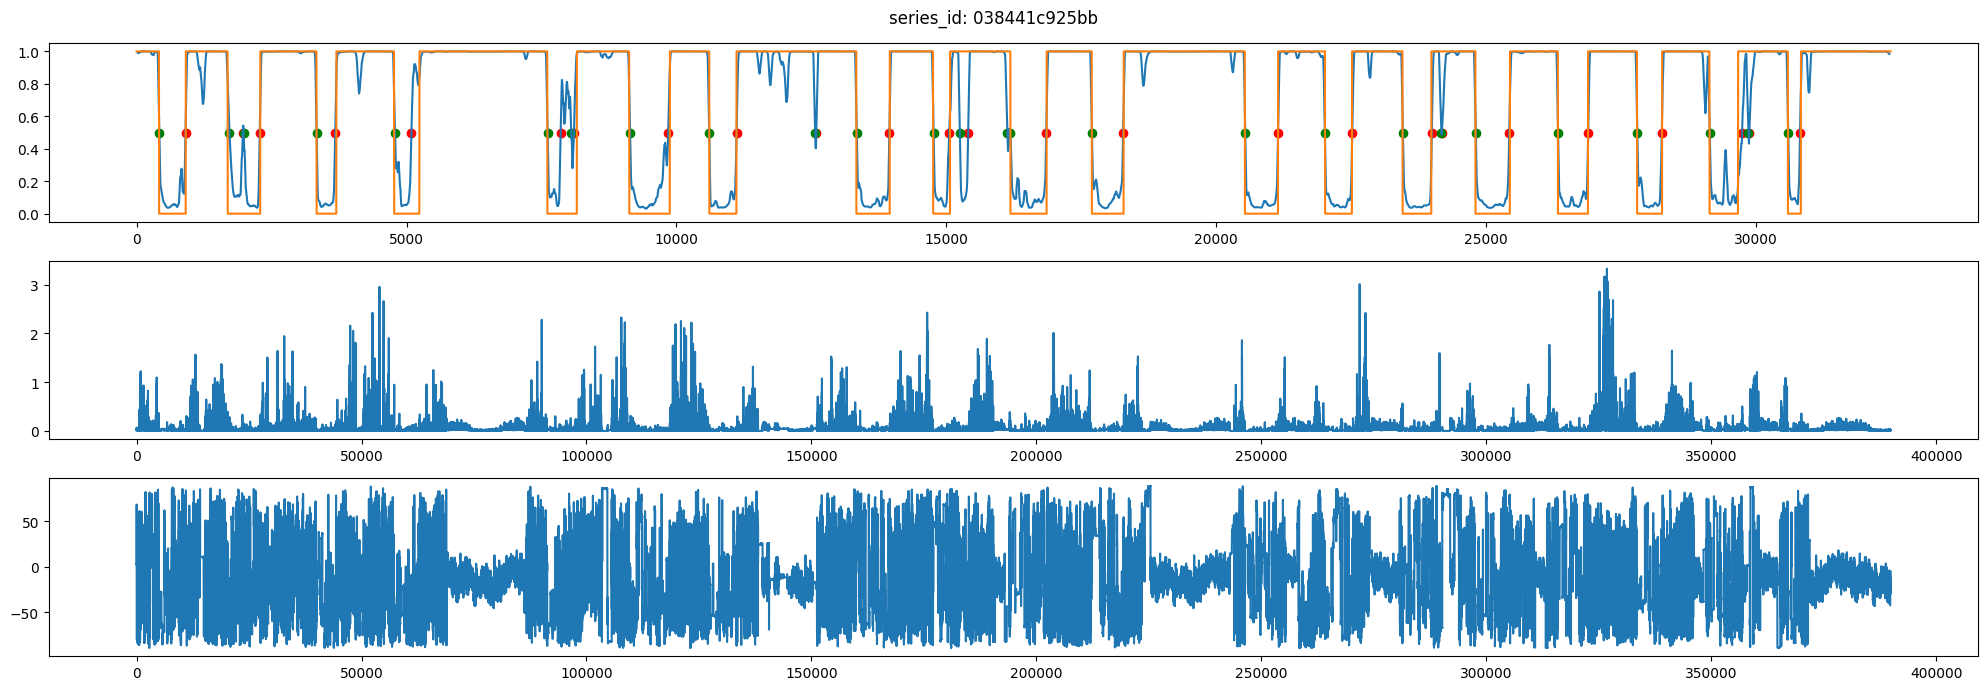

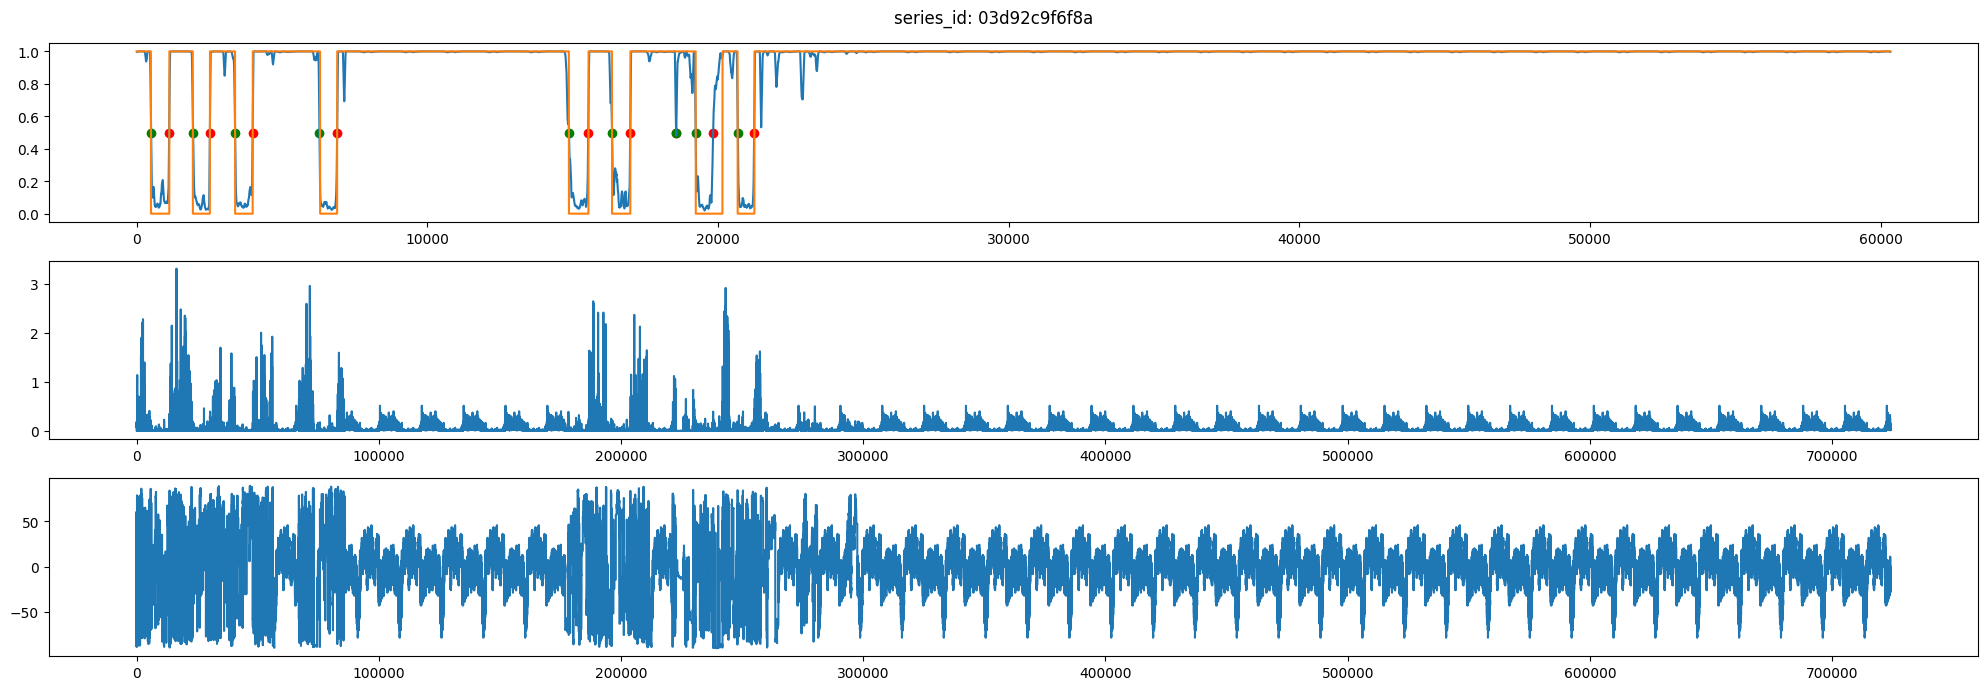

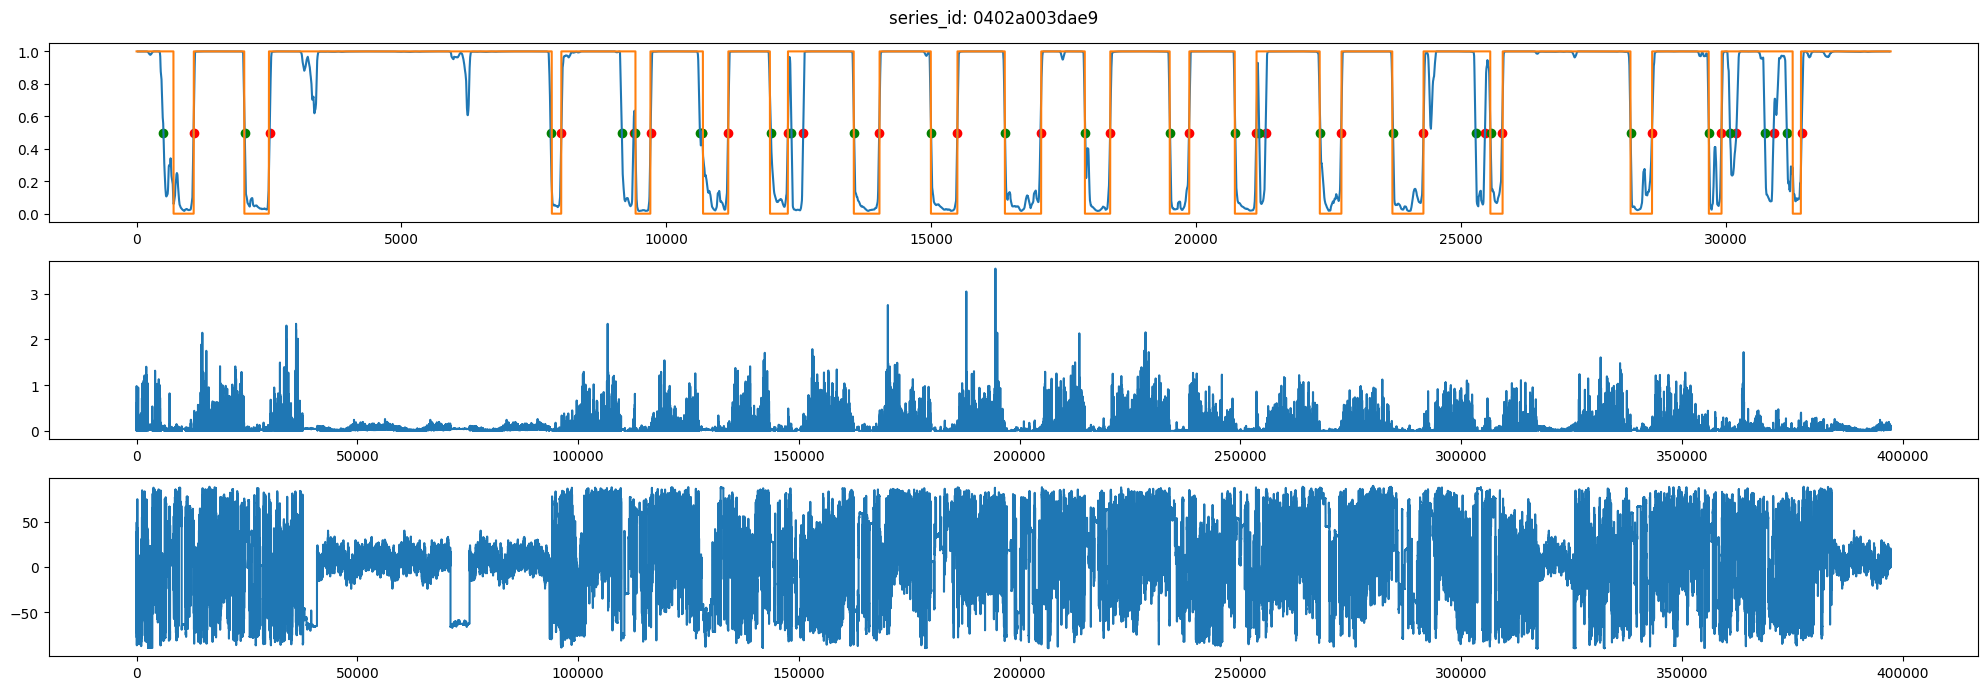

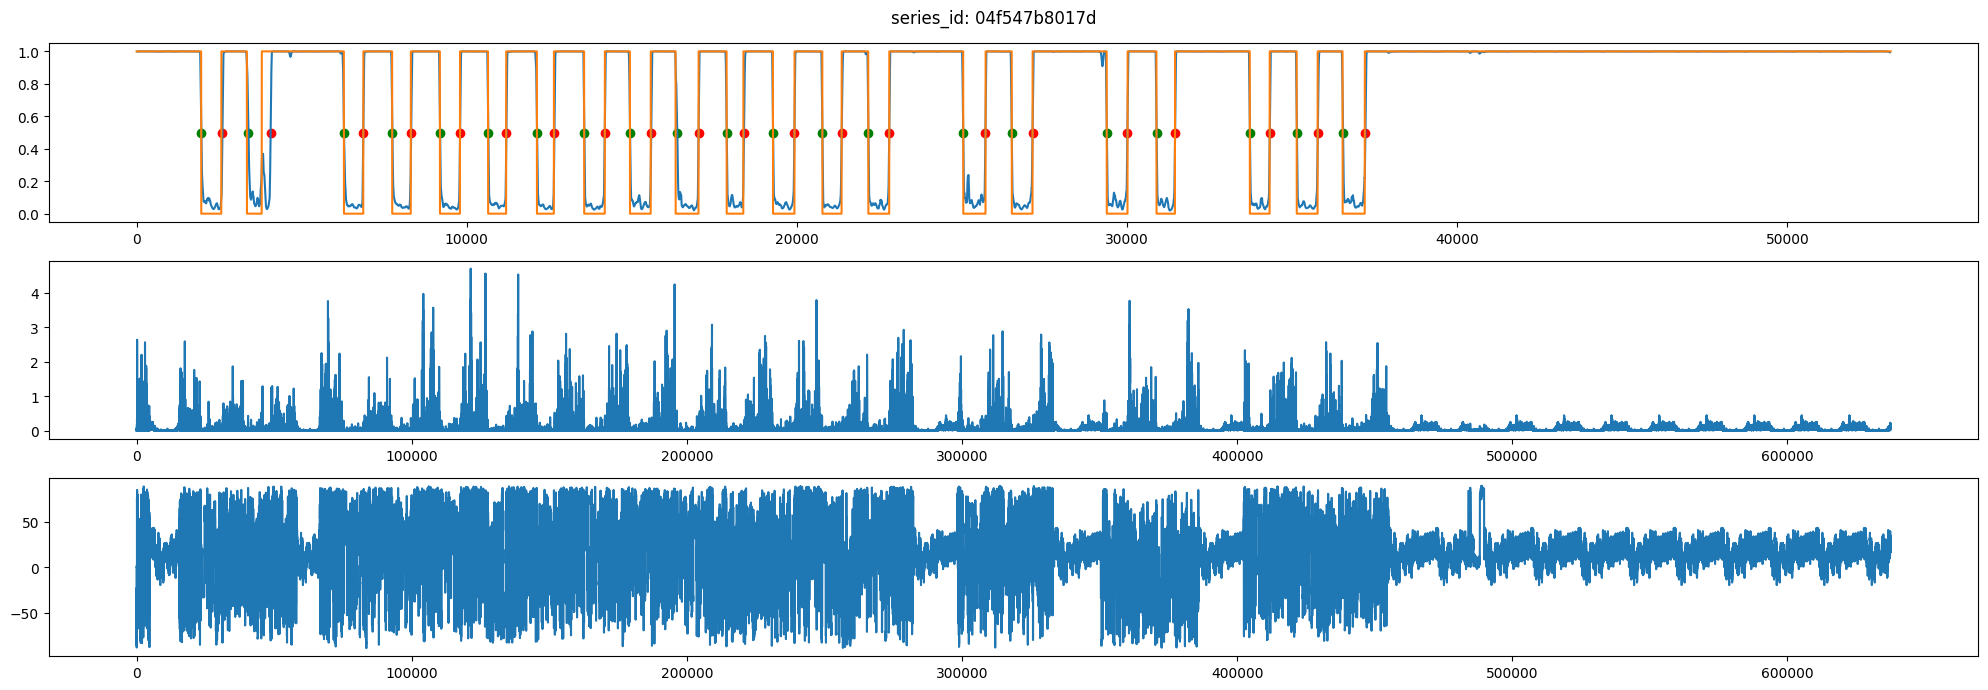

,series_id,step,event,score
0,038441c925bb,10883,wakeup,1
1,038441c925bb,23627,wakeup,1
2,038441c925bb,27383,wakeup,1
3,038441c925bb,44159,wakeup,1
4,038441c925bb,61103,wakeup,1


In [9]:
dfs = []
oofs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    df["raw_oof"] = df["oof"]
    df["oof"] = df["oof"].rolling(48, center=True).mean()
    oofs.append(df)
    wakeup_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] < 0.5 and df["oof"][i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] > 0.5 and df["oof"][i] <= 0.5])

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[wakeup_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "wakeup",
            "score": 1,
        }) if len(wakeup_index) > 0 else pd.DataFrame(),
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[onset_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "onset",
            "score": 1,
        }) if len(onset_index) > 0 else pd.DataFrame(),
    ])
    if len(sub) > 0:
        sub["step"] = sub["step"].astype(int)
        dfs.append(sub)

    if len(dfs) < 5:
        fig, axs = plt.subplots(3, 1, figsize=(20, 7))
        axs[0].plot(df["oof"])
        axs[0].plot(df["target"])
        axs[0].scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        axs[0].scatter(onset_index, [0.5 for _ in onset_index], c="green")
        df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{df['series_id'].values[0]}.csv")
        axs[1].plot(df["enmo"])
        axs[2].plot(df["anglez"])
        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

train = pd.concat(oofs)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)
sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

score: 0.3671


event   tolerance
onset   12           0.003858
        36           0.030886
        60           0.095764
        90           0.207601
        120          0.360159
        150          0.442522
        180          0.503632
        240          0.576857
        300          0.618546
        360          0.637112
wakeup  12           0.004887
        36           0.048127
        60           0.140896
        90           0.297540
        120          0.399091
        150          0.486835
        180          0.541472
        240          0.615822
        300          0.653137
        360          0.676786
dtype: float64

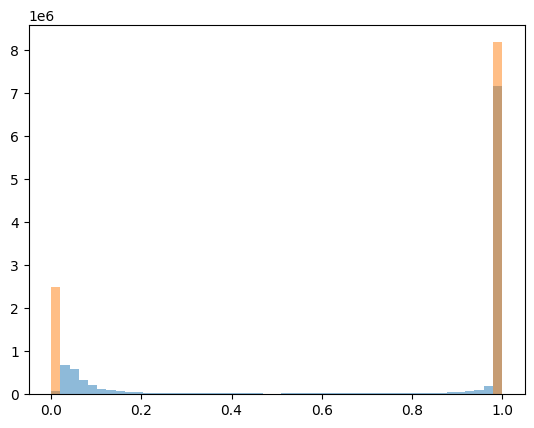

In [10]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()

In [11]:
# 次の候補の大きさ
next_cand_size = 0
count = 0
next_dict = {}
for series_id, train_df in train.groupby("series_id"):
    train_df = train_df[(train_df["oof"] >= 0.1) & (train_df["oof"] <= 0.9)]
    sub_df = sub[(sub["series_id"] == series_id)]
    label_df = labels[labels["series_id"] == series_id]
    pred_steps = train_df["step"].values
    sub_steps = sub_df["step"].values
    label_steps = label_df["step"].values

    if len(train_df) == 0:
        continue
    next_cand = np.zeros(int(max(max(pred_steps if len(pred_steps) > 0 else [0]), max(sub_steps if len(sub_steps) > 0 else [0]))) + CFG["feature"]["agg_freq"])
    for sub_step in sub_steps:
        next_cand[int(sub_step - CFG["feature"]["agg_freq"] * 10): int(sub_step + CFG["feature"]["agg_freq"] * 10)] = 1
    for pred_step in pred_steps:
        next_cand[int(pred_step - CFG["feature"]["agg_freq"] * 10): int(pred_step + CFG["feature"]["agg_freq"] * 10)] = 1
    next_cand_size += np.sum(next_cand)
    next_dict[series_id] = np.where(next_cand)[0]

    for label_step in label_steps:
        if label_step < next_cand.shape[0]:
            count += next_cand[int(label_step)]
    
recall = count / len(labels)
print(f"recall: {recall:.4f}")
print(f"next_cand_size: {next_cand_size}")

recall: 0.9661
next_cand_size: 17806284.0


In [12]:
import pickle

with open(f"{CFG['output_dir']}/next_cands.pkl", "wb") as f:
    pickle.dump(next_dict, f)